# Organización de Datos (9558)

## Trabajo Práctico N° 2

#### Fecha de entrega: 2017-06-15

#### Integrantes:
- Rodrigo Aparicio, 98967

- Thomas Cordeu, 99288

- Mariano Kakazu, 98178


#### Repositorio:
[Github - TP2](https://github.com/frisjon/tp2) ( https://github.com/frisjon/tp2 )

---
Tabla de contenidos

1. [Descripción](#descripcion)

2. [Sets de datos y Feature Engineering](#feat_eng)

3. [Visualizaciones](#visu)

4. [Probando algoritmos](#algoritmos)

5. [Conclusiones y Comentarios](#conclusiones)

---
<a id='descripcion'></a>
### 1. [Descipción](https://inclass.kaggle.com/c/san-francisco-biking)

El propósito de esta competencia es predecir la duración de los viajes.

El objetivo de esta competencia es predecir la duración de los viajes de acuerdo a los datos de los mismos, la información meteorológica, etc.

Pueden usarse los siguientes archivos disponibles en:

https://www.kaggle.com/benhamner/sf-bay-area-bike-share

    .status
    .station 
    .weather

Para los viajes debe usarse el archivo train.csv provisto par entrenar el modelo y el archivo test.csv tiene los datos de los viajes a predecir.

---
<a id='feat_eng'></a>
### 2. Sets de Datos y Feature Engineering

En esta sección analizamos los datos a modo de preparación para entrenar a los algoritmos.

Los sets de datos son:

>[Entrenamiento y testeo](https://inclass.kaggle.com/c/san-francisco-biking/data) ( https://inclass.kaggle.com/c/san-francisco-biking/data )

>[Set de datos del TP1](https://www.kaggle.com/benhamner/sf-bay-area-bike-share) ( https://www.kaggle.com/benhamner/sf-bay-area-bike-share )


Para manejar y visualizar los datos, utilizamos *pandas*.

In [3]:
#Importamos los modulos necesarios para manejar los datos
import time
start = time.time()

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Leemos los datos del set de entrenamiento y el de test
train = pd.read_csv('./data/train.csv', low_memory=False)
test  = pd.read_csv('./data/test.csv' , low_memory=False)

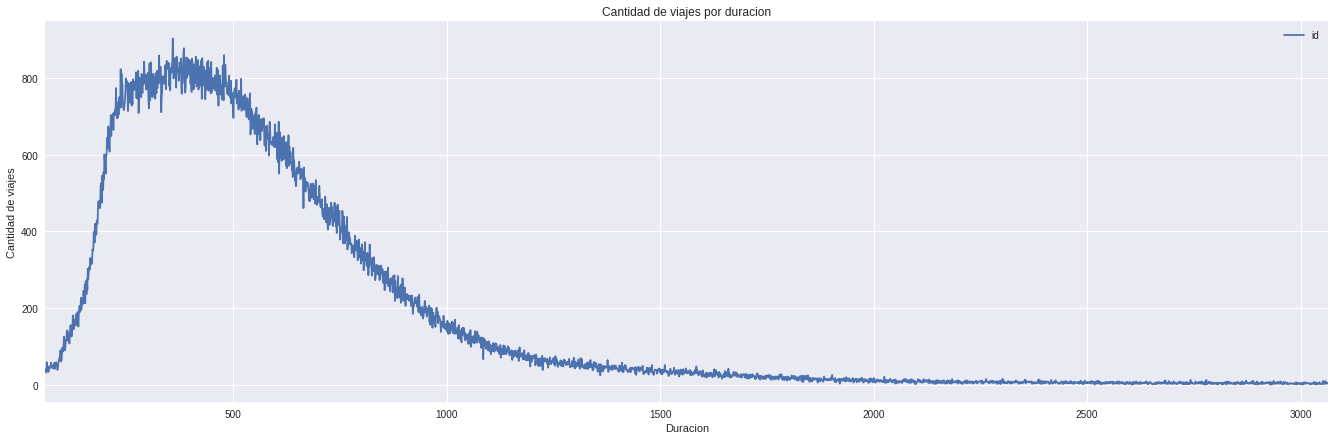

In [5]:
#Plot de duraciones de viajes y cantidad de viajes con determinada duracion
train[['id', 'duration']].groupby('duration').count().head(3000).plot(figsize=(23, 7));
plt.title('Cantidad de viajes por duracion');
plt.xlabel('Duracion');
plt.ylabel('Cantidad de viajes');

Del gráfico se observa que hay una gran cantidad de viajes de duración entre 200 y 600 segundos. (__Atención__: En el gráfico se muestran 3.000 de 14.614 duraciones diferentes)

In [6]:
#Cambiamos los nombres de los features, para que sea mas facil de leer.
nombres = {'subscription_type':  'sub_type',
           'start_station_name': 'ss_name',
           'end_station_name':   'es_name',
           'start_station_id':   'sid',
           'end_station_id':     'es_id',
           'start_date':         's_date',
           'end_date':           'e_date',
           'zip_code':           'z_code',
           'bike_id':            'b_id'}

train.rename(columns=nombres, inplace=True)
test.rename( columns=nombres, inplace=True)

In [7]:
def subscriber(sub_type):
    if sub_type == 'Customer': return 0
    return 1

In [8]:
#Copiamos el set de datos y lo modificamos lo menos posible para realizar una reduccion de dimensiones
cp_train = train
cp_train = cp_train.drop(['ss_name','es_name','z_code'], axis=1)
cp_train['s_date'] = pd.to_datetime(cp_train['s_date'], format='%m/%d/%Y %H:%M').astype(np.int64) // 10**9
cp_train['e_date'] = pd.to_datetime(cp_train['e_date'], format='%m/%d/%Y %H:%M').astype(np.int64) // 10**9
cp_train['sub_type'] = cp_train['sub_type'].map(subscriber)

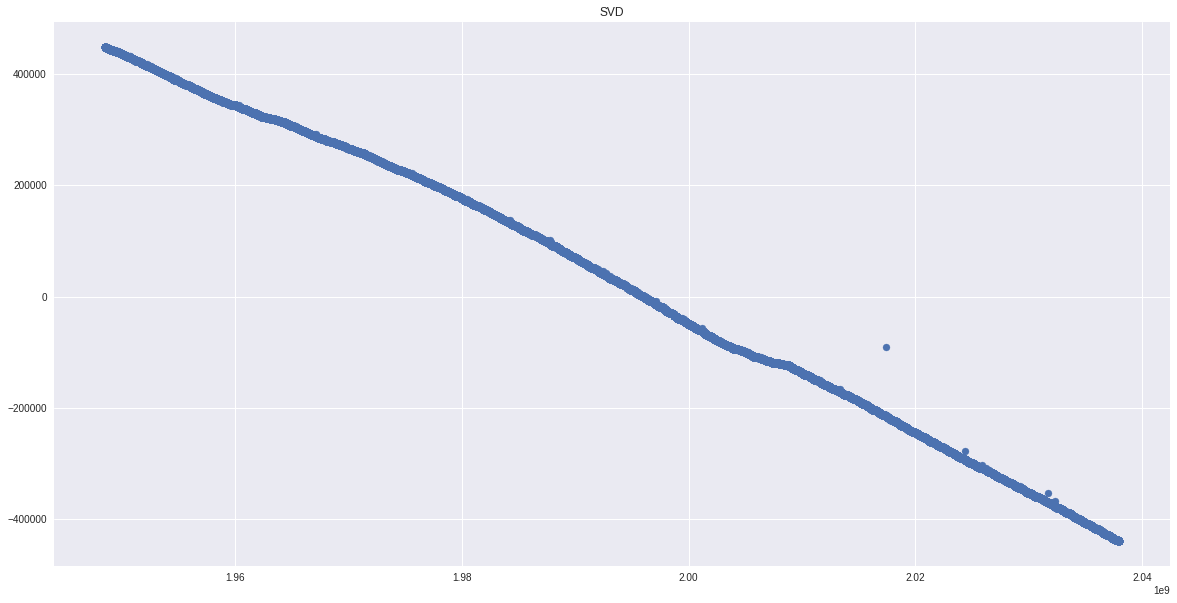

In [9]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7)
X   = svd.fit_transform(cp_train.values)

plt.figure(figsize=(20, 10));
plt.title('SVD');
plt.scatter(X[:, 0], X[:, 1]);

In [10]:
#Quitamos algunos features innecesarios y que no se pueden utilizar
train.drop(['ss_name', 'es_name', 'z_code', 'e_date','es_id','id'], axis=1, inplace=True)
test.drop (['ss_name', 'es_name', 'z_code', 'e_date','es_id'     ], axis=1, inplace=True)

train['s_date'] = pd.to_datetime(train['s_date'], format='%m/%d/%Y %H:%M')
test ['s_date'] = pd.to_datetime(test ['s_date'], format='%m/%d/%Y %H:%M')

train['year'] = train['s_date'].map(lambda x:x.year).astype(np.uint16)
test ['year'] = test ['s_date'].map(lambda x:x.year).astype(np.uint16)

train['month'] = train['s_date'].map(lambda x:x.month).astype(np.uint8)
test ['month'] = test ['s_date'].map(lambda x:x.month).astype(np.uint8)

train['day'] = train['s_date'].map(lambda x:x.day).astype(np.uint8)
test ['day'] = test ['s_date'].map(lambda x:x.day).astype(np.uint8)

train['weekday'] = train['s_date'].map(lambda x: x.weekday()).astype(np.uint8)
test ['weekday'] = test ['s_date'].map(lambda x: x.weekday()).astype(np.uint8)

train['hour'] = train['s_date'].map(lambda x:x.hour).astype(np.uint8)
test ['hour'] = test ['s_date'].map(lambda x:x.hour).astype(np.uint8)

train['minute'] = train['s_date'].map(lambda x:x.minute).astype(np.uint8)
test ['minute'] = test ['s_date'].map(lambda x:x.minute).astype(np.uint8)

train['date'] = pd.DatetimeIndex(train['s_date']).normalize()
test ['date'] = pd.DatetimeIndex(test ['s_date']).normalize()

train = train.merge(pd.get_dummies(train['sub_type']), left_index=True, right_index=True)
test  =  test.merge(pd.get_dummies(test ['sub_type']), left_index=True, right_index=True)

train.drop('sub_type', axis=1, inplace=True)
test.drop ('sub_type', axis=1, inplace=True)

#Quitamos los viajes de mas de 6 horas. (6*60*60 = 21600)
train = train[train.duration <= 21600]

#### Añadiendo información del clima y estaciones

Ahora agregamos información respecto al clima y estaciones.

##### Clima

In [11]:
#Cargamos el set del clima
weather = pd.read_csv('./data/weather.csv', low_memory=False)

In [12]:
def zip_ciudad(zip_code):
    '''Funcion para determinar el nomber de la ciudad a partir del codigo zip'''
    if    zip_code == 95113: return 'San Jose'
    elif  zip_code == 94301: return 'Palo Alto'
    elif  zip_code == 94107: return 'San Francisco'
    elif  zip_code == 94063: return 'Redwood City'
    else:                    return 'Mountain View'

def season(date):
    '''Funcion para determinar la estacion del anio'''
    if   3 <= date.month and date.month <= 5:  return 'Spring'
    elif 6 <= date.month and date.month <= 8:  return 'Summer'
    elif 9 <= date.month and date.month <= 11: return 'Fall'
    else:                                      return 'Winter'

In [13]:
#Cambiamos los nombres de los features, para que sea mas facil de leer.
rename = {'mean_sea_level_pressure_inches': 'mean_press',
          'max_sea_level_pressure_inches' : 'max_press',
          'min_sea_level_pressure_inches' : 'min_press',
          'precipitation_inches'          : 'precipitation',
          'mean_visibility_miles'         : 'mean_vis',
          'max_visibility_miles'          : 'max_vis',
          'min_visibility_miles'          : 'min_vis',
          'mean_temperature_f'            : 'mean_temp_f',
          'max_temperature_f'             : 'max_temp_f',
          'min_temperature_f'             : 'min_temp_f',
          'mean_wind_speed_mph'           : 'mean_wind',
          'max_wind_Speed_mph'            : 'max_wind',
          'max_gust_speed_mph'            : 'max_gust',
          'mean_dew_point_f'              : 'mean_dew_f',
          'max_dew_point_f'               : 'max_dew_f',
          'min_dew_point_f'               : 'min_dew_f',
          'wind_dir_degrees'              : 'wind_dir',
          'mean_humidity'                 : 'mean_hum',
          'max_humidity'                  : 'max_hum',
          'min_humidity'                  : 'min_hum',
          'zip_code'                      : 'z_code'
         }

weather.rename(columns=rename, inplace=True)

In [14]:
#Convertimos la fecha a un formato manejable
weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%Y')

#Corregimos algunos datos
weather.loc[weather['events'] == 'rain', 'events'] = 'Rain'
weather.loc[weather['events'].isnull() , 'events'] = 'Normal'

#Convertimos los eventos del clima en features
weather = weather.merge(pd.get_dummies(weather['events']), left_index=True, right_index=True)

#Agregamos un feature para luego hacer un merge con los datos de train y test
weather['city'] = weather['z_code'].map(zip_ciudad)

#Agregamos los features de las estaciones del anio
weather['season'] = weather['date'].map(season)
weather = weather.merge(pd.get_dummies(weather['season']), left_index=True, right_index=True)

#Quitamos el feature de precipitacion, porque hay un dato en particular que no podemos convertir/reparar.
weather.drop(['precipitation','season','events'], axis=1, inplace=True)

#Quitamos las filas con valores invalidos
for i in weather:
    weather.drop(weather.loc[weather[i].isnull()].index, inplace=True)

##### Estaciones

In [15]:
#Cargamos el set de las estaciones
stations = pd.read_csv('./data/station.csv', low_memory=False)

#Cambiamos el nombre de un feature para hacer un merge con los datos de los viajes
stations.rename(columns={'id':'sid'}, inplace=True)

#Quitamos los features innecesarios
stations.drop(['name','lat','long','installation_date'], axis=1, inplace=True)

Ahora juntamos los datos en un solo dataframe.

In [16]:
#Merge con datos de las estaciones
datos      = pd.merge(train, stations, how='inner', on='sid')
test_final = pd.merge(test,  stations, how='inner', on='sid')

#Merge con datos del clima
datos      = pd.merge(datos,      weather, how='inner', on=['date','city'])
test_final = pd.merge(test_final, weather, how='outer', on=['date','city'])

#Convertimos en features a la ciudad en donde comienza el viaje
datos      =      datos.merge(pd.get_dummies(datos['city']),      left_index=True, right_index=True)
test_final = test_final.merge(pd.get_dummies(test_final['city']), left_index=True, right_index=True)

#Quitamos los features que fueron utilizados para el merge
datos.drop(     ['s_date','date','z_code','city'], axis=1, inplace=True)
test_final.drop(['s_date','date','z_code','city'], axis=1, inplace=True)

#Quitamos los datos invalidos en el set de test que se agregaron luego del merge con weather
test_final.drop(test_final[test_final['id'].isnull()].index, inplace=True)

#Rellenamos los datos faltantes con valores validos anteriores
#Creemos que esto es razonable ya que los datos faltantes son solamente del clima en algunos dias
#Asumiendo que el clima no varia mucho cada dia, completamos los datos faltantes con los datos de dias previos
test_final.fillna(method='pad', inplace=True)

---
<a id='visu'></a>
### 3. Visualizaciones

Veamos como se comportan cada feature con respecto a la duracion del viaje

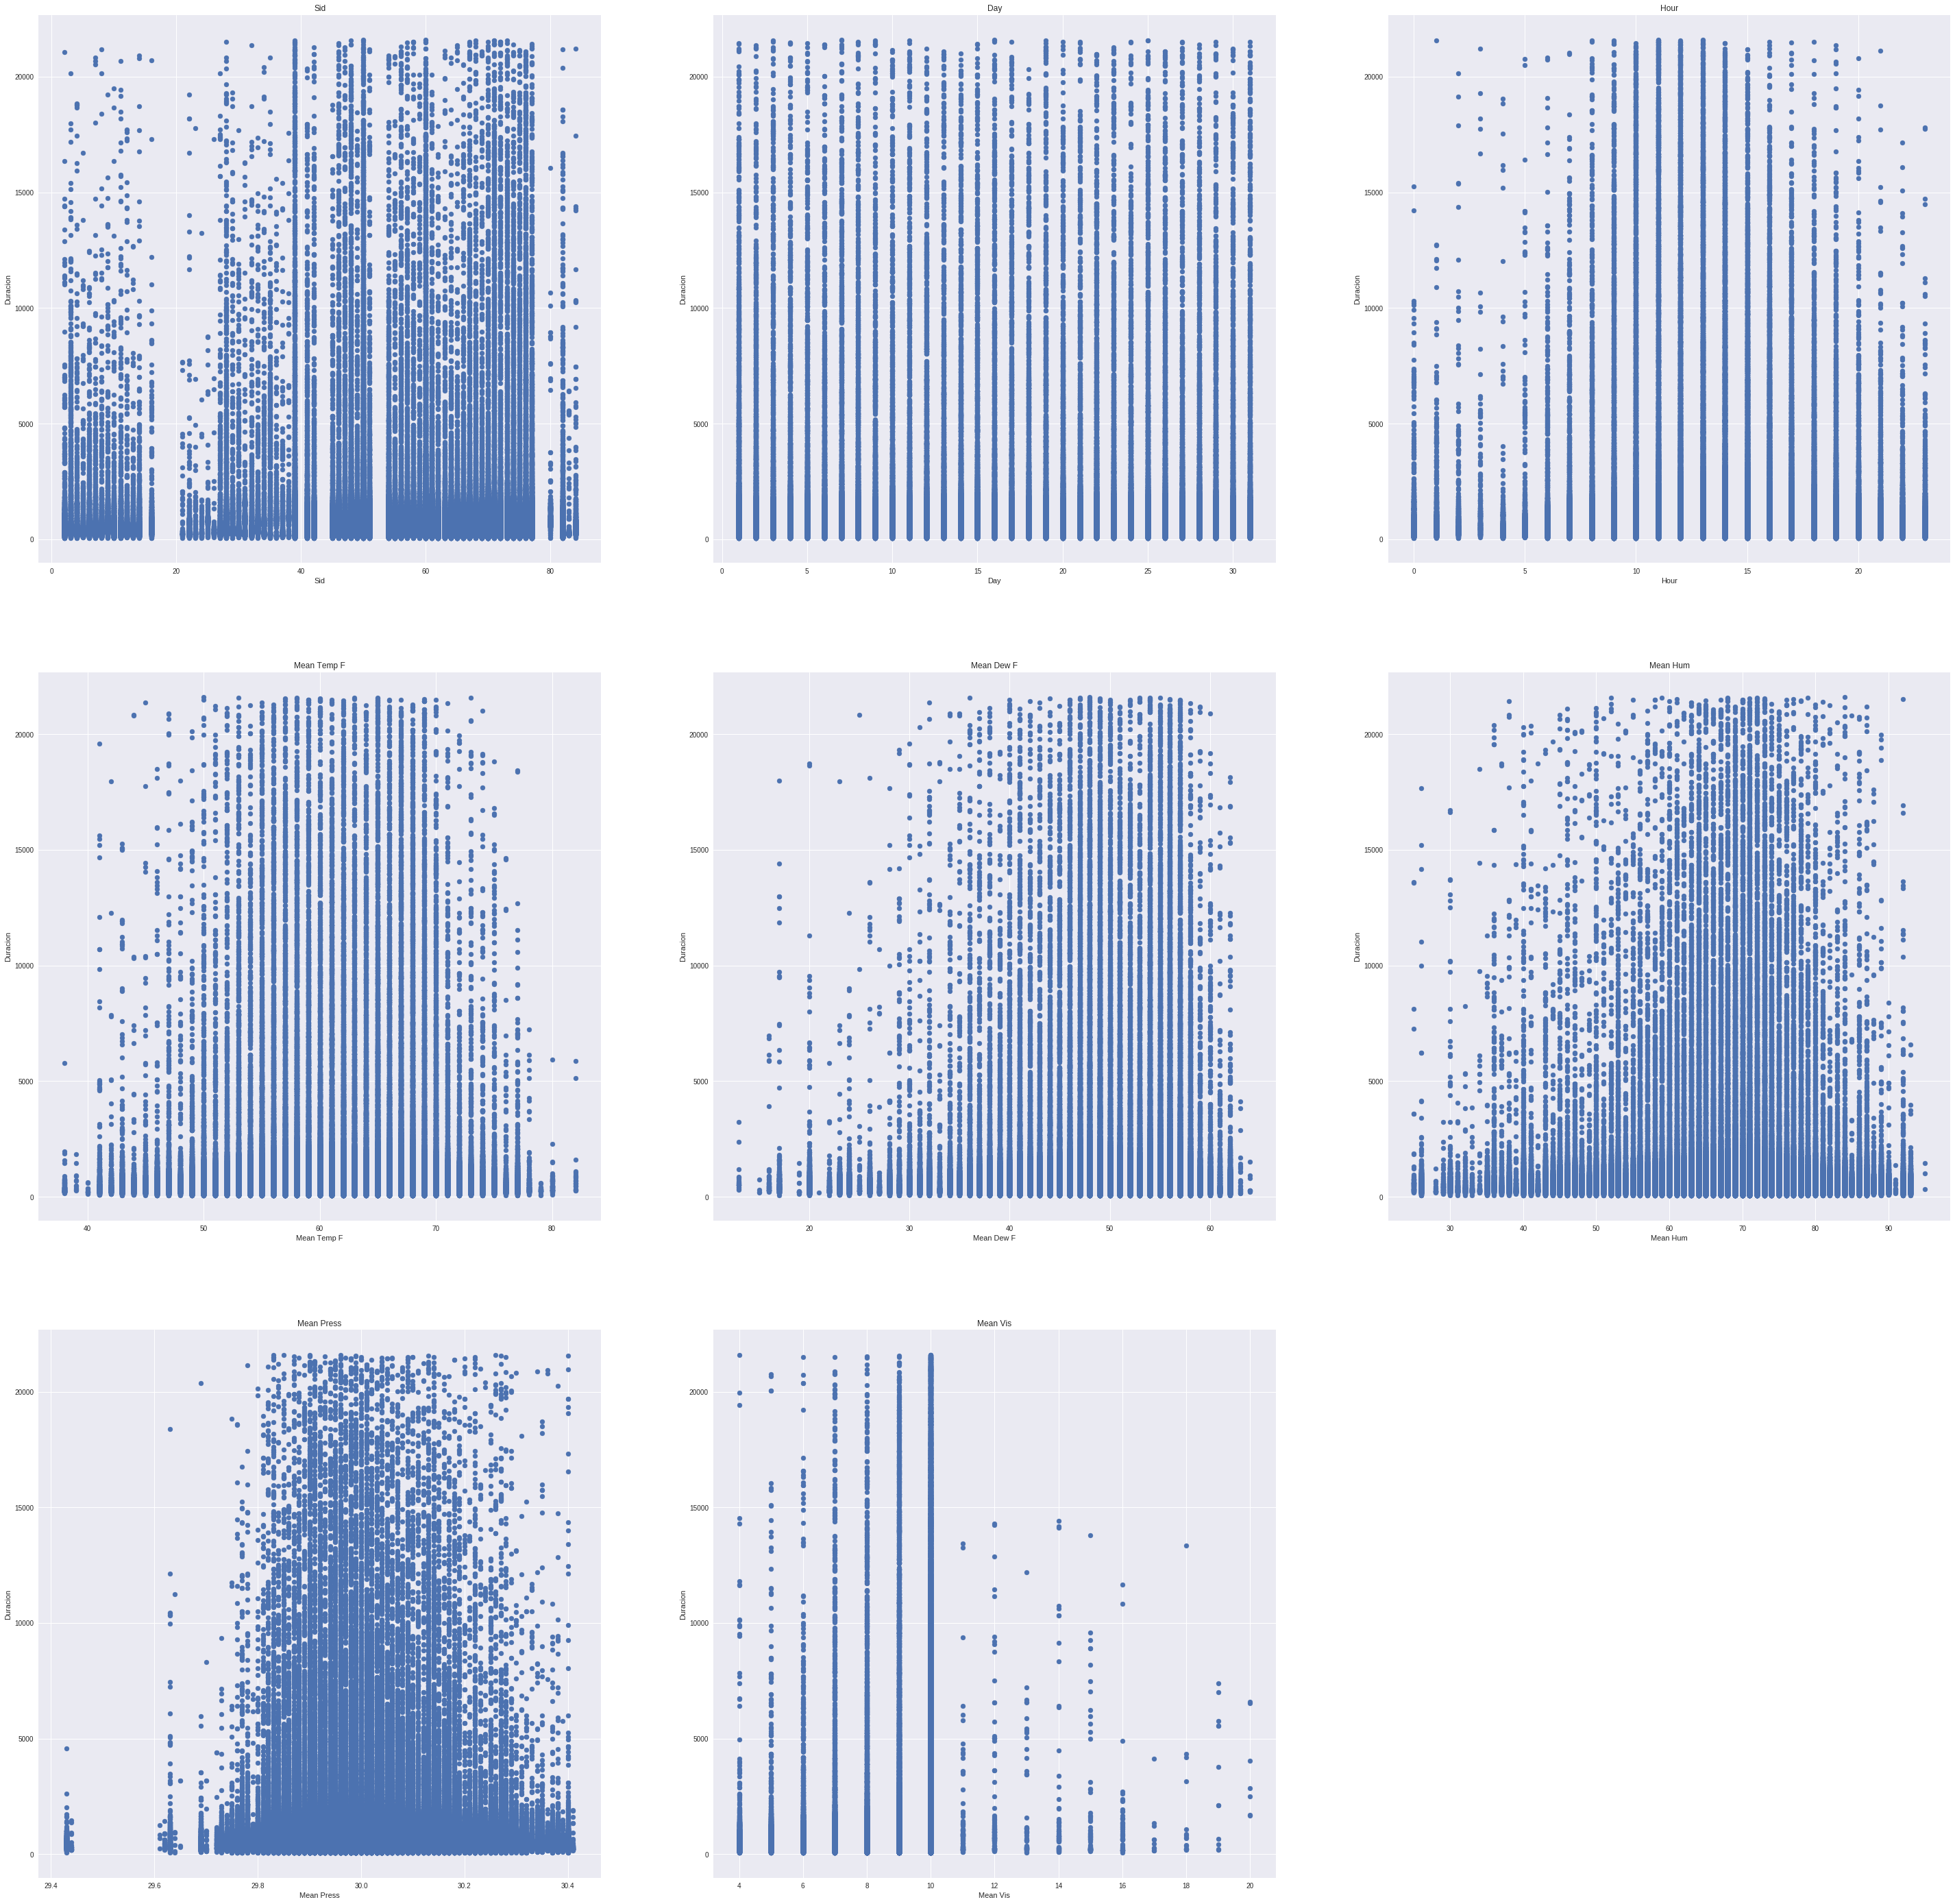

In [17]:
features = ['sid','day','hour','mean_temp_f','mean_dew_f','mean_hum','mean_press','mean_vis','mean_wind']
plt.figure(figsize=(50, 50))

for i in range(len(features)-1):
    plt.subplot(3, 3, i+1);
    titulo = features[i].replace('_', ' ').title()
    plt.title(titulo);
    plt.scatter(datos[features[i]], datos['duration']);
    plt.xlabel(titulo);
    plt.ylabel('Duracion');

plt.show()

No se muestran todos los features contra la duracion del viaje, solo los plots un poco mas interesantes.

##### SVD

Aplicando SVD a los datos con mas features, vemos la distribucion de los datos en 2D.

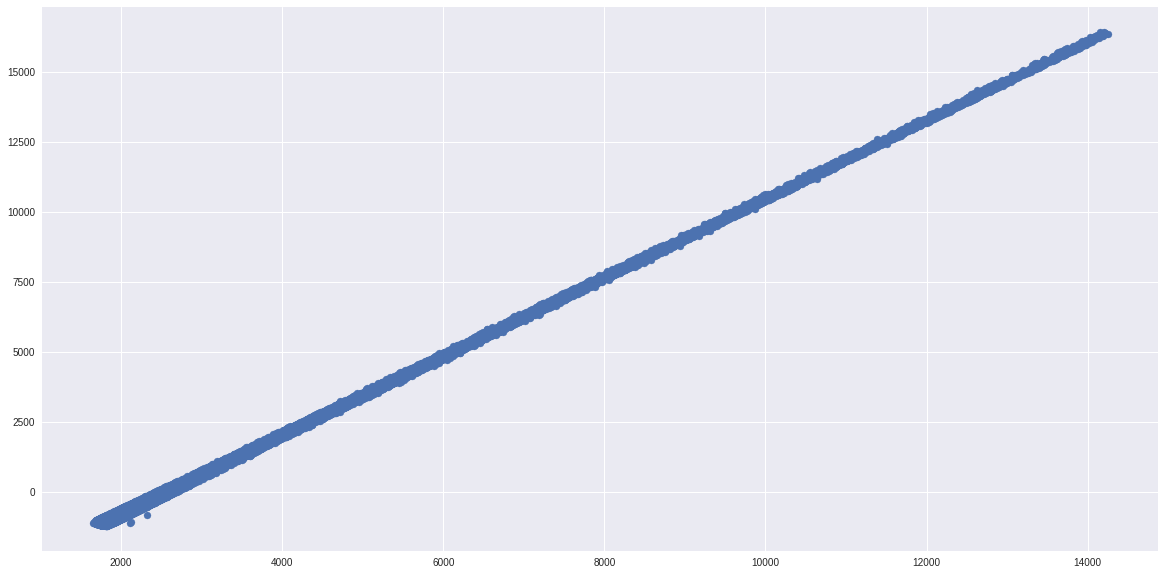

In [18]:
svd = TruncatedSVD(n_components=2, n_iter=7)
X   = svd.fit_transform(datos.values)

plt.figure(figsize=(20, 10));
plt.scatter(X[:, 0], X[:, 1]);

Se puede observar una relación lineal con los datos luego de haberlos modificado.

---
Normalizamos los datos

In [19]:
from sklearn.preprocessing import normalize

#Separamos la duracion del viaje de los datos de entrenamiento
duraciones = datos['duration'].values
datos      = normalize(datos.drop(['duration'], axis=1))

#Separamos las identificaciones del viaje para generar el archivo de entrega al final
ids_final  = test_final['id'].values
test_final = normalize(test_final.drop(['id'], axis=1))

---
<a id='algoritmos'></a>
### 4. Probando algoritmos

Hechos algunos análisis, pasamos ahora a entrenar varios algoritmos y ver como se desarrollan con nuestro set de datos.

Decidimos utilizar scikit-learn por la gran cantidad de algoritmos que ya están implementados. [SciKit-Learn](http://scikit-learn.org/stable/index.html)

In [20]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import *
from sklearn.neural_network import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import *
from sklearn.ensemble import * 
from sklearn.tree import *
from sklearn.svm import SVR

In [21]:
#Creamos algunos estimadores de regresion para comparalos entre si. Luego vamos a elegir el/los algoritmos con 
#mejor puntuacion, que son los que tienen menos error.
estimadores = {
    PassiveAggressiveRegressor():'PassiveAggressive',
    GradientBoostingRegressor() :'GrandientBoosting',
    GaussianProcessRegressor()  :'GaussianProcess',
    RandomForestRegressor()     :'RandomForest',
    DecisionTreeRegressor()     :'DecisionTree',
    ExtraTreesRegressor()       :'ExtraTrees',
    KNeighborsRegressor()       :'KNN',
    AdaBoostRegressor()         :'AdaBoost',
    TheilSenRegressor()         :'TheilSen',
    LinearRegression()          :'Linear',
    BaggingRegressor()          :'Bagging',
    RANSACRegressor()           :'RANSAC',
    HuberRegressor()            :'Huber',
    PLSRegression()             :'PLS',
    BayesianRidge()             :'BayesRidge',
    SGDRegressor()              :'SGD',
    MLPRegressor()              :'MLP',
    KernelRidge()               :'KernelRidge',
    LassoLars()                 :'LassoLars',
    RidgeCV()                   :'RidgeCV',
    SVR()                       :'SVR'
}

#En esta lista registramos el error y los tiempos tomados por cada algoritmo
performance = []

In [22]:
def plots_de_predictores(num, a, b):
    '''Funcion para entrenar a estimadores con un tamanio de set de datos determinado'''
    x = datos[:num]
    y = duraciones[:num]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    plt.figure(figsize=(40, 40));
    i=1
    for est in estimadores:
        t1 = time.time()
        est.fit(X_train, y_train)
        t2 = time.time()
        tiempo = t2 - t1
        predicciones = est.predict(X_test)
        error = mse(predicciones, y_test)
        plt.subplot(a, b, i)
        plt.title(estimadores[est] + ' ' + str(error))
        plt.plot(predicciones)
        plt.plot(y_test)
        i+=1
        performance.append(('%.f'%error, estimadores[est], '%.3f'%tiempo))

/home/mk/p2env/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


('16571563225209', 'PLS', '0.006')
('3620632', 'TheilSen', '10.434')
('3670479', 'LassoLars', '0.024')
('3695086', 'BayesRidge', '0.011')
('3708819', 'Linear', '0.009')
('3870578', 'GaussianProcess', '1.063')
('3891316', 'GrandientBoosting', '0.809')
('4076422', 'RandomForest', '0.620')
('4193168', 'RANSAC', '0.108')
('4236758', 'RidgeCV', '0.013')
('4267510', 'Bagging', '0.611')
('4294031', 'ExtraTrees', '0.209')
('4381469', 'KernelRidge', '0.691')
('4454123', 'SGD', '0.005')
('4524052', 'MLP', '2.910')
('4577661', 'Huber', '0.142')
('4708702', 'SVR', '0.740')
('4719612', 'PassiveAggressive', '0.004')
('4955570', 'AdaBoost', '0.107')
('5023267', 'KNN', '0.005')
('6783768', 'DecisionTree', '0.098')


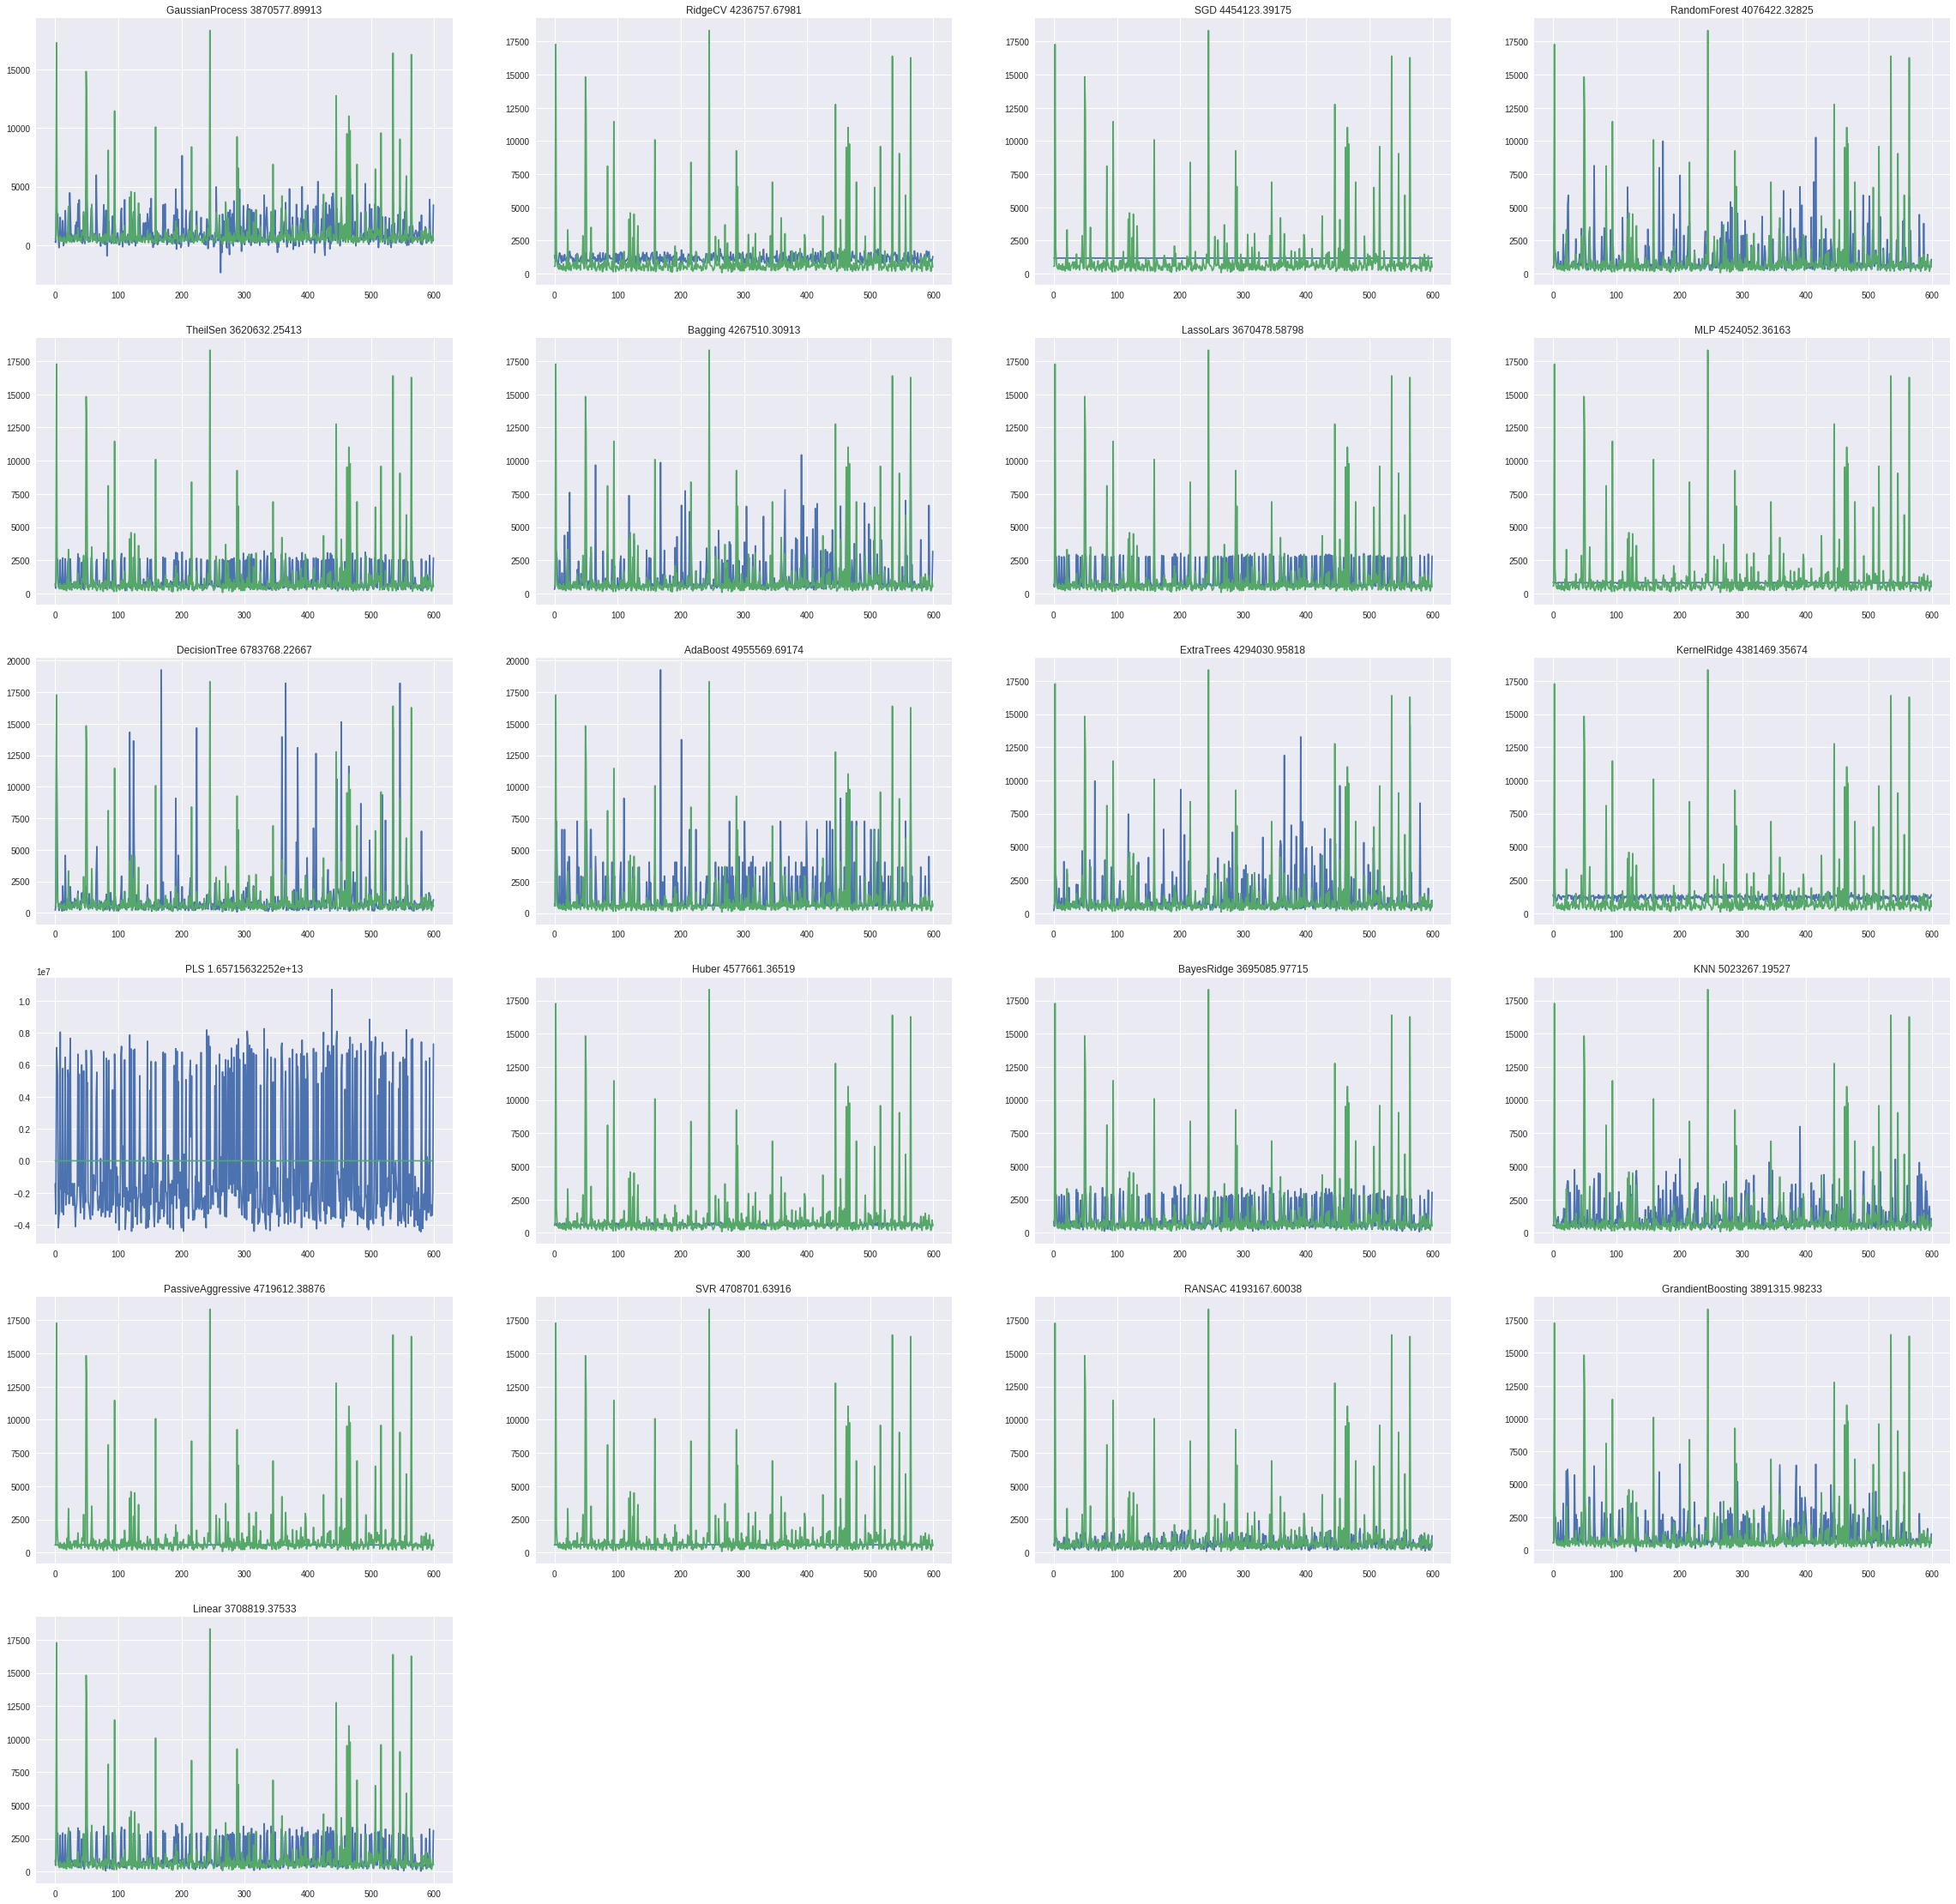

In [23]:
performance = []
plots_de_predictores(3000, 6, 4)

#Ordenamos a los estimadores segun el error cometido al estimar
performance.sort()

for est in performance:
    print est

Viendo los scores de cada algoritmo, elegimos a los que tuvieron mejor rendimiento:

    GradientBoostingRegressor()    
    RandomForestRegressor()    
    DecisionTreeRegressor()    
    ExtraTreesRegressor()
    KNeighborsRegressor()
    LinearRegression()
    BaggingRegressor()

A continuación vamos a evaluarlos con una mayor cantidad de datos con esperanzas de reducir el error cometido al estimar.

In [24]:
#Redefinimos a los estimadores
estimadores = {
    GradientBoostingRegressor() :'GrandientBoosting',
    RandomForestRegressor()     :'RandomForest',
    DecisionTreeRegressor()     :'DecisionTree',
    ExtraTreesRegressor()       :'ExtraTrees',
    KNeighborsRegressor()       :'KNN',
    LinearRegression()          :'Linear',
    BaggingRegressor()          :'Bagging'
}

('2422245', 'Linear', '0.022')
('2571511', 'GrandientBoosting', '2.638')
('2636017', 'RandomForest', '2.721')
('2816983', 'ExtraTrees', '0.713')
('2967613', 'Bagging', '2.779')
('3214647', 'KNN', '0.014')
('4255838', 'DecisionTree', '0.465')


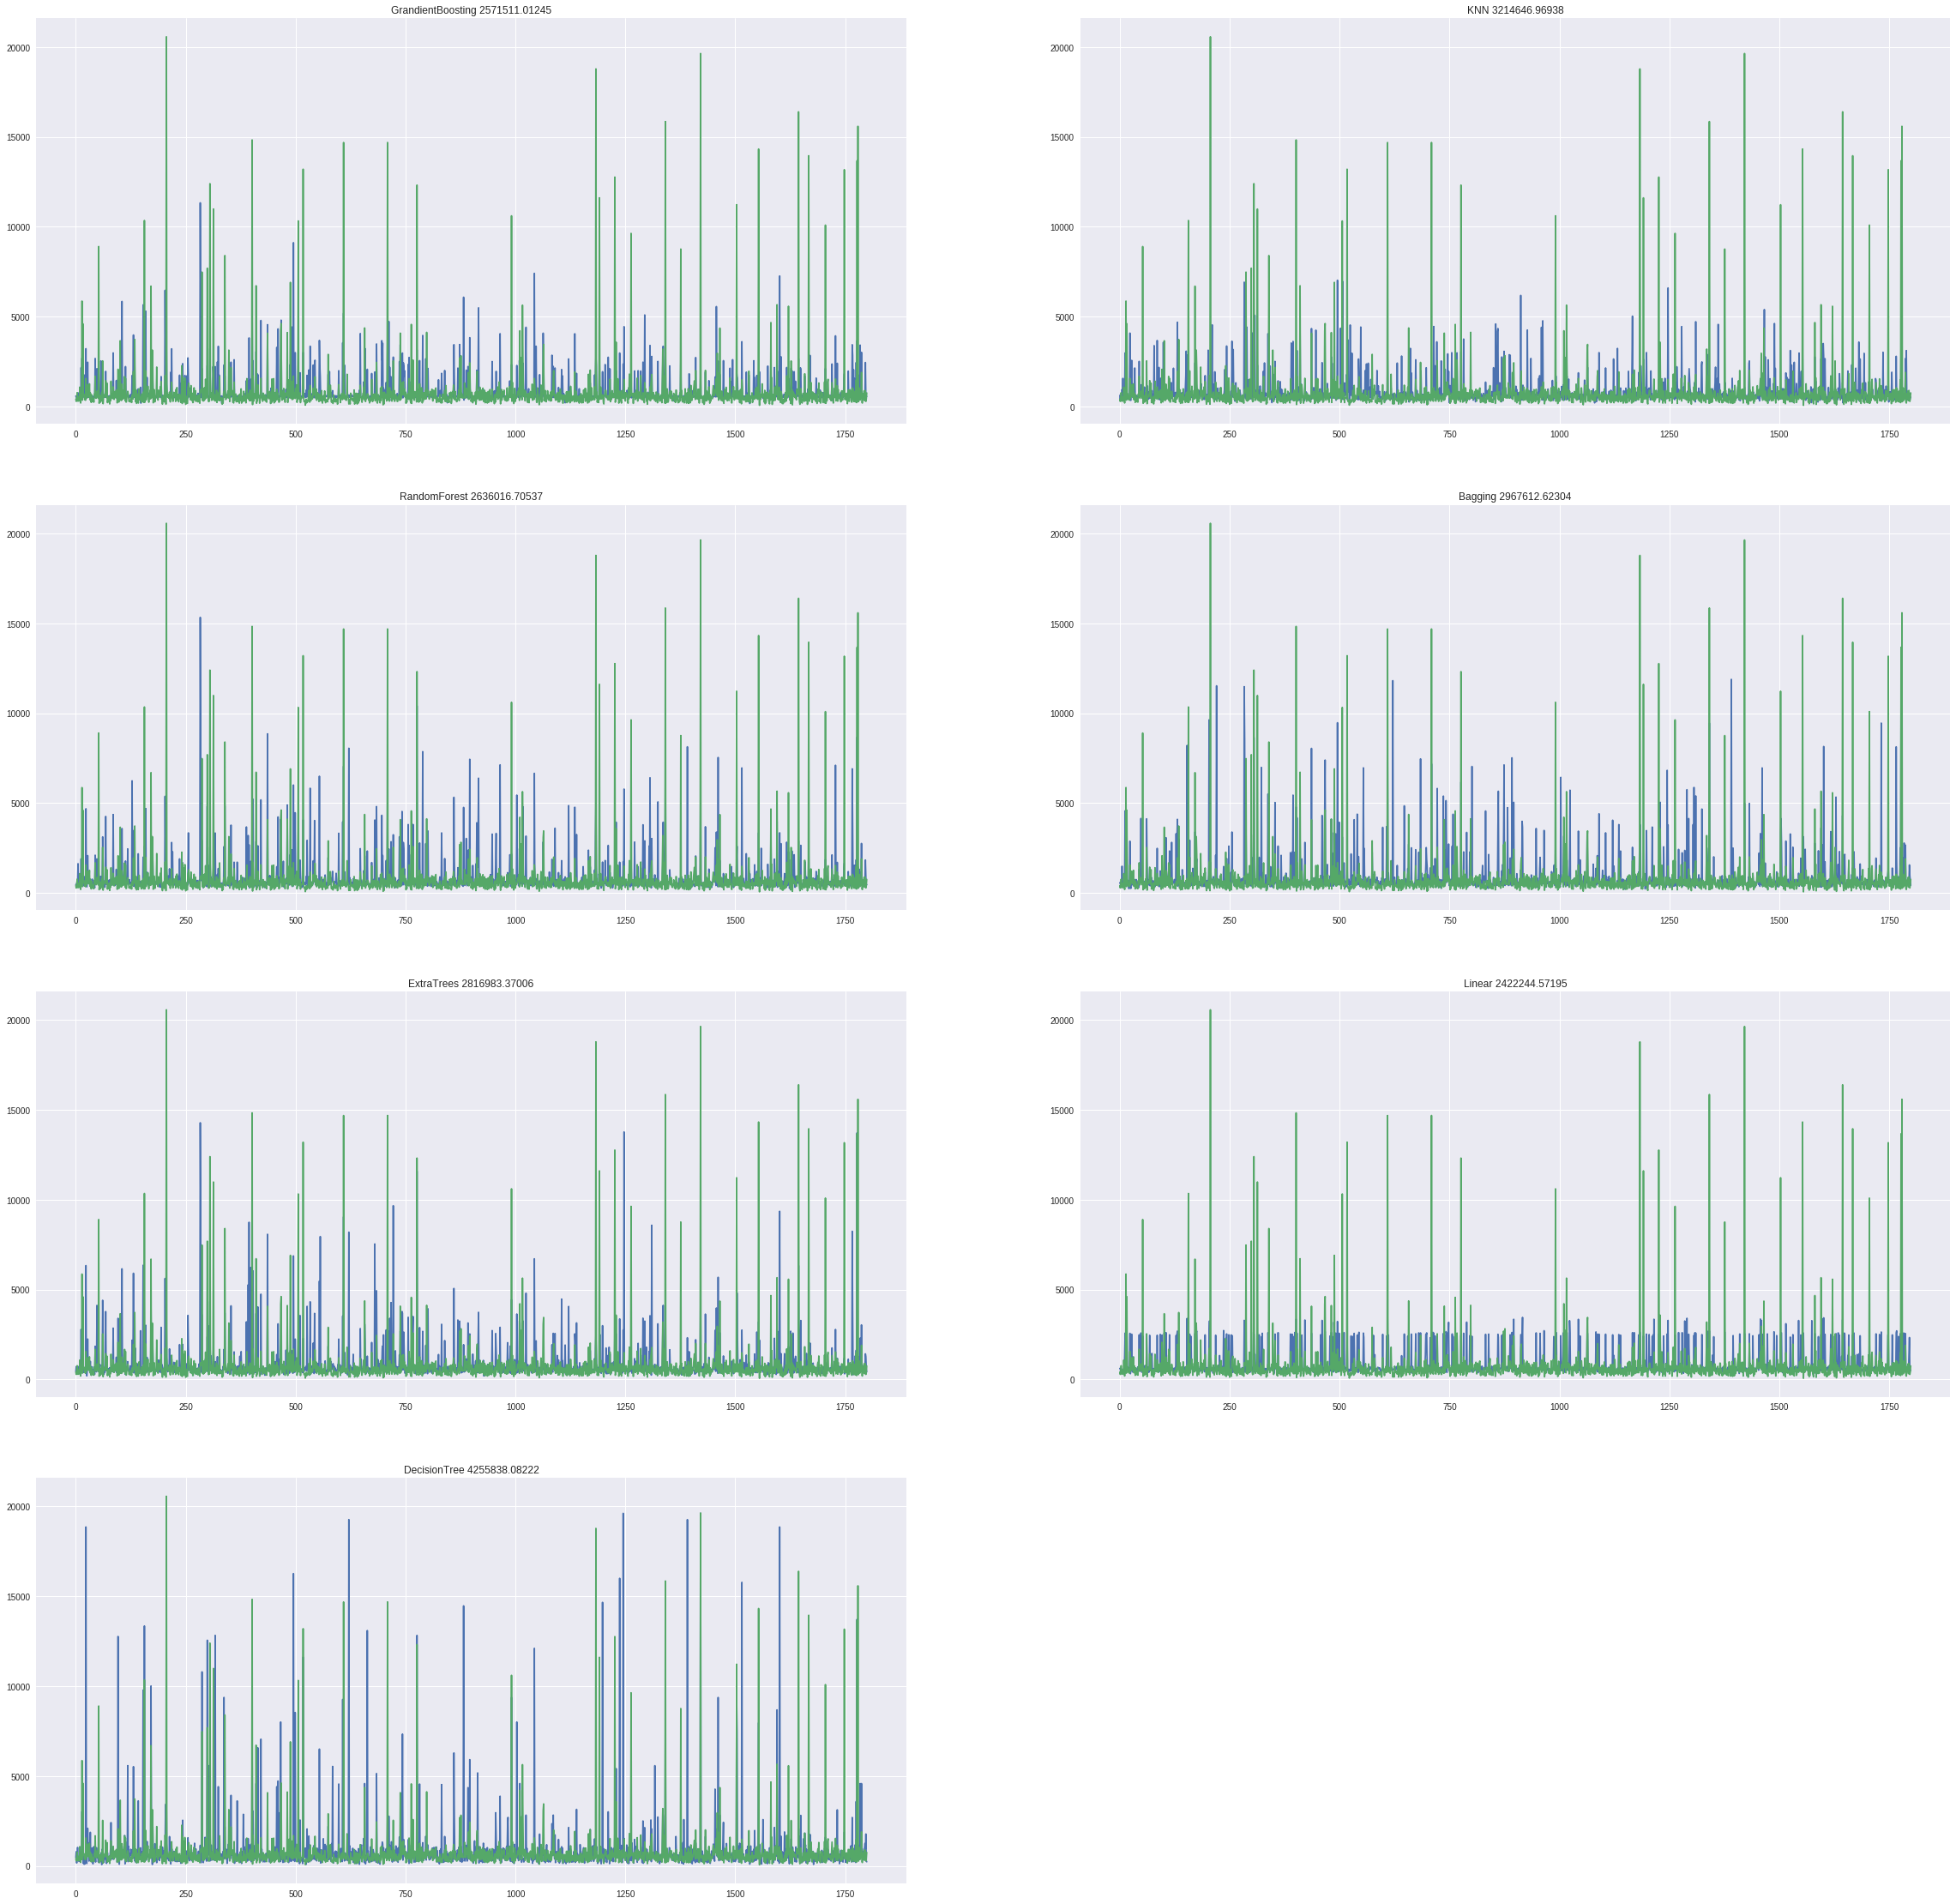

In [25]:
#Limpiamos la lista de performance
performance = []

plots_de_predictores(9000, 4, 2)

#Ordenamos a los estimadores segun el error cometido al estimar
performance.sort()

for est in performance:
    print est

El estimador ExtraTrees fue el que tuvo mejores resultados dentro de todos los estimadores. Decimos enforcarnos en este algoritmo.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(datos, duraciones, test_size=0)

def extra_trees(num_estimadores):
    est = ExtraTreesRegressor(n_estimators=num_estimadores)
    est.fit(X_train, y_train)
    predicciones = est.predict(test_final)
    return predicciones

In [27]:
predicciones = extra_trees(10)

(gridsearch con pocos datos sobre el algoritmo ExtraTrees)

Generamos el archivo de la entrega

In [28]:
entrega = open('submission.csv','w')
entrega.write('id,duration\n')

for i in range(len(ids_final)):
    entrega.write('%.f'%ids_final[i]+','+'%.f'%predicciones[i]+'\n')

entrega.close()

In [29]:
end = time.time()
print end-start

295.127458096


---
<a id='conclusiones'></a>
### 5. Conclusiones y Comentarios